In [473]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import scipy
import importlib
import os, sys
import seaborn as sns
import tqdm
from pandas_datareader import data

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct

# Sector Index

load data

Text(0, 0.5, 'ESG Score')

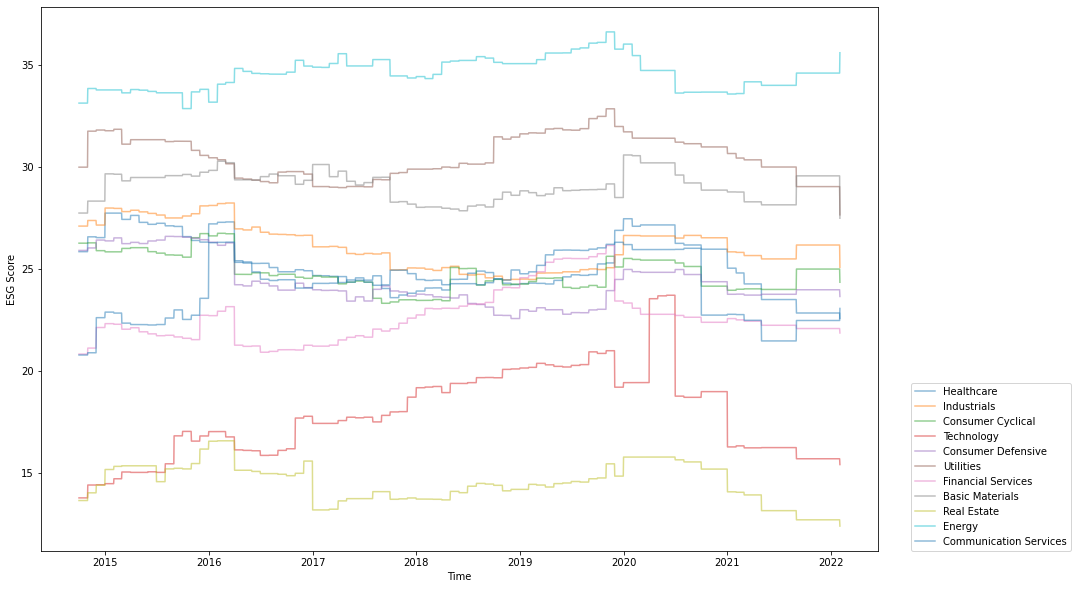

In [474]:
sector_esg = pd.read_pickle('../Yahoo/sector_index_no_diff.pkl')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for sector in sector_esg.columns:

    y = sector_esg[sector].fillna(method='ffill')

    out = ax.plot(sector_esg.index, y, alpha = 0.5, label = sector)
    # legend_ticks.append(sector)

ax.legend(loc=(1.04,0))
ax.set_xlabel("Time")
ax.set_ylabel("ESG Score")

In [475]:
sector = 'Real Estate'

In [476]:
X = np.array(range(len(sector_esg.index)))
y = np.array(sector_esg[sector])

y_obs = y[np.isfinite(y)]
X_obs = np.expand_dims(X[np.isfinite(y)], axis = 1)
X = np.expand_dims(X, axis=1)




And the differenced

Text(0, 0.5, 'ESG Score')

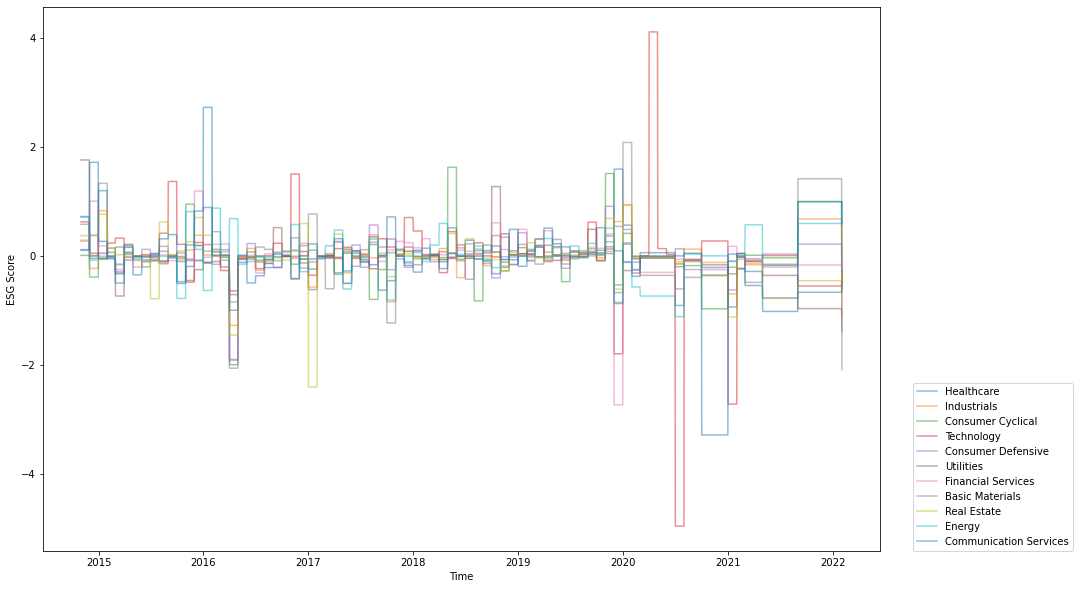

In [477]:
sector_esg_diff = pd.read_pickle('../Yahoo/sector_index.pkl')
X_diff = np.array(range(len(sector_esg_diff.index)))
y_diff = np.array(sector_esg_diff[sector])

y_obs_diff = y_diff[np.isfinite(y_diff)]
X_obs_diff = np.expand_dims(X_diff[np.isfinite(y_diff)], axis = 1)
X_diff = np.expand_dims(X_diff, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for sector in sector_esg_diff.columns:

    y = sector_esg_diff[sector].fillna(method='ffill')

    out = ax.plot(sector_esg_diff.index, y, alpha = 0.5, label = sector)
    # legend_ticks.append(sector)

ax.legend(loc=(1.04,0))
ax.set_xlabel("Time")
ax.set_ylabel("ESG Score")

In [478]:
def fit_and_print(kernel_tests, X_obs, y_obs):

    for idx in range(len(kernel_tests)): 
        gp = gaussian_process.GaussianProcessRegressor(kernel=kernel_tests[idx], n_restarts_optimizer=50)
        out_gp = gp.fit(X_obs, y_obs)
        print(f'{out_gp.kernel_} {out_gp.log_marginal_likelihood()}')

def plot_fit(gp, X_obs, y_obs):
    X = np.linspace(X_obs[0], X_obs[-1], 500)
    mean_prediction, std_prediction = gp.predict(X, return_std=True)


    fig, ax = plt.subplots(1,1, figsize = (20,10))
    #plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    ax.scatter(X_obs, y_obs, label="Observations")
    ax.plot(X, mean_prediction, label="Mean prediction")
    ax.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.set_title(f"{gp.kernel_}")

Test multiple kernel

In [479]:
kernel_tests = [Matern(length_scale=1, nu = 0.5), Matern(length_scale=1, nu = 1.5), Matern(length_scale=1, nu = 2.5),
                RBF(length_scale=1), 1*Matern(length_scale=1, nu = 0.5), 1*Matern(length_scale=1, nu = 1.5), 1*Matern(length_scale=1, nu = 2.5),
                1*RBF(length_scale=1), RationalQuadratic(), 1*RationalQuadratic()
                ]
fit_and_print(kernel_tests, X_obs, y_obs)

Matern(length_scale=1.26e+03, nu=0.5) -303.44339350225556
Matern(length_scale=166, nu=1.5) -1054.3241513261114
Matern(length_scale=94.7, nu=2.5) -1596.0667680187898
RBF(length_scale=40.5) -2976.800018473607
13.1**2 * Matern(length_scale=5.43e+04, nu=0.5) -51.4020416240951
10.8**2 * Matern(length_scale=407, nu=1.5) -91.58686010899811
10.1**2 * Matern(length_scale=155, nu=2.5) -125.00760161092833
10.1**2 * RBF(length_scale=46.1) -200.83026208728342
RationalQuadratic(alpha=0.0323, length_scale=42.5) -200.20246818893912
14.3**2 * RationalQuadratic(alpha=0.000503, length_scale=673) -54.36140077306984


According to the log likelihood, we should choose matern 0.5 kernel with length_scale ~5000 and scale to 13.1. But that is basically linear interpolation

13.1**2 * Matern(length_scale=5.43e+04, nu=0.5)


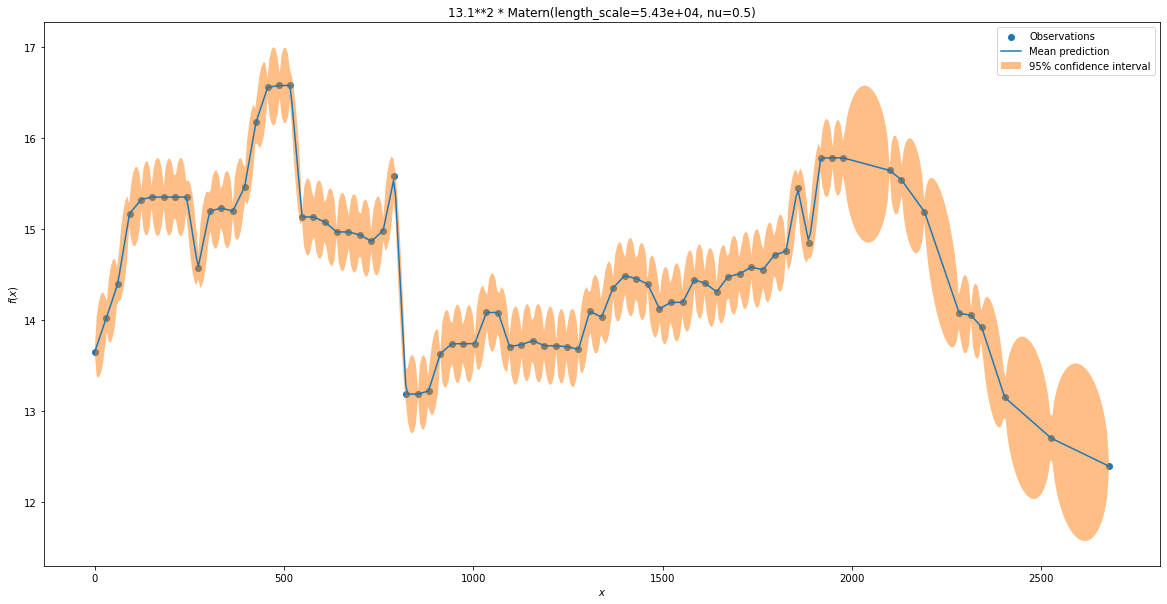

In [468]:
gp = gaussian_process.GaussianProcessRegressor(kernel=1*Matern(length_scale=1, nu = 0.5), n_restarts_optimizer=50).fit(X_obs, y_obs)
print(gp.kernel_)
plot_fit(gp, X_obs, y_obs)

Compare to matern with nu 1.5

10.8**2 * Matern(length_scale=407, nu=1.5)


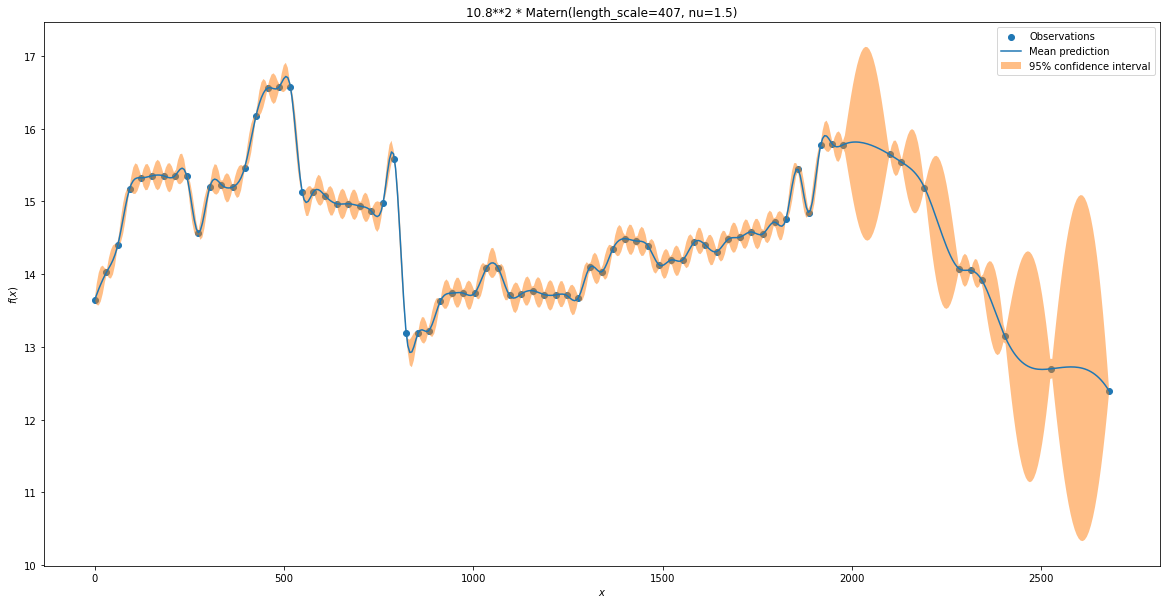

In [469]:

gp = gaussian_process.GaussianProcessRegressor(kernel=1*Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=50).fit(X_obs, y_obs)
print(gp.kernel_)
plot_fit(gp, X_obs, y_obs)

What happens if I allows noisy observations.

10.8**2 * Matern(length_scale=2.29e+03, nu=1.5)
-62.45141475414033


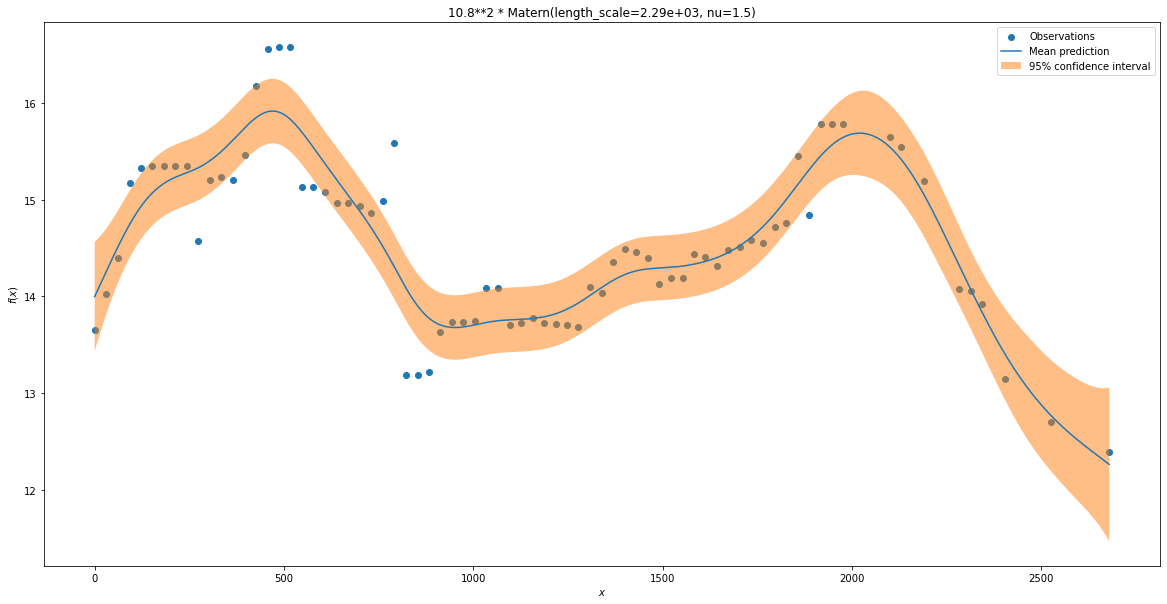

In [488]:
gp = gaussian_process.GaussianProcessRegressor(kernel=1*Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=50, alpha = 0.2).fit(X_obs, y_obs)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, X_obs, y_obs)

We can look at the differenced series as well

In [430]:
fit_and_print(kernel_tests, X_obs_diff, y_obs_diff)

Matern(length_scale=101, nu=0.5) -68.21065909104776
Matern(length_scale=34.9, nu=1.5) -72.7287386317283
Matern(length_scale=29.1, nu=2.5) -73.44007380391618
RBF(length_scale=1) -75.91997952408394
0.463**2 * Matern(length_scale=0.000381, nu=0.5) -47.958086197260414
0.463**2 * Matern(length_scale=0.00022, nu=1.5) -47.95808619726043
0.463**2 * Matern(length_scale=0.865, nu=2.5) -47.95808619726043
0.463**2 * RBF(length_scale=1e-05) -47.95808619726042


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gives lower log likelihood. Including Scale does seems to same value for all kernels. Let's look at a kernel with and without scaling

0.463**2 * Matern(length_scale=1e-05, nu=0.5)


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


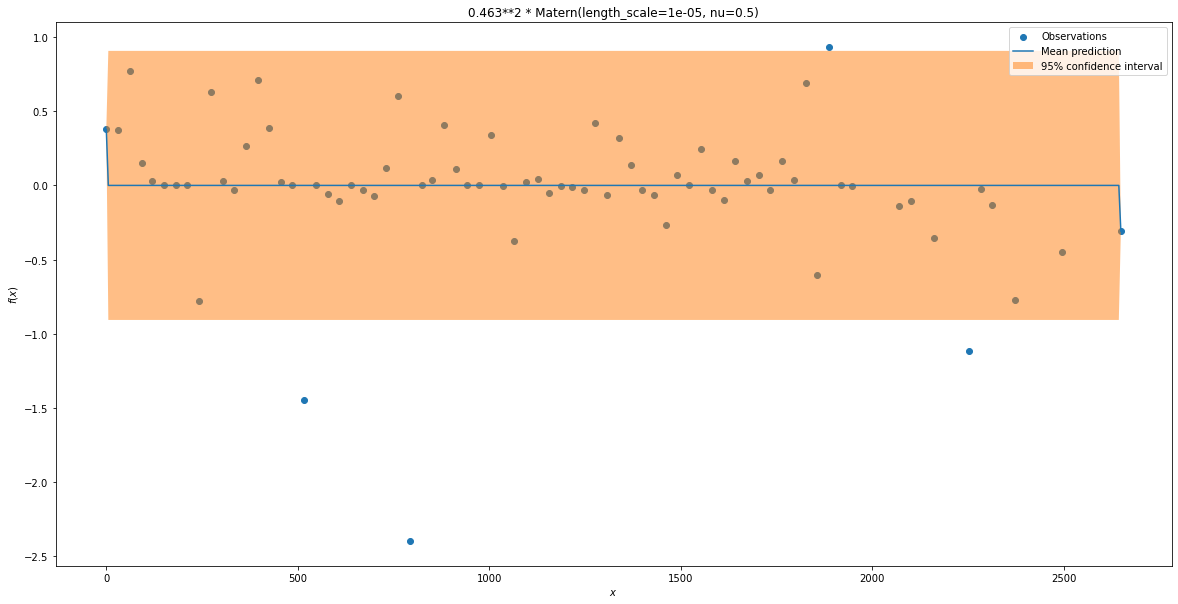

In [483]:
gp = gaussian_process.GaussianProcessRegressor(kernel=1*Matern(length_scale=1, nu = 0.5), n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
plot_fit(gp, X_obs_diff, y_obs_diff)

Matern(length_scale=101, nu=0.5)


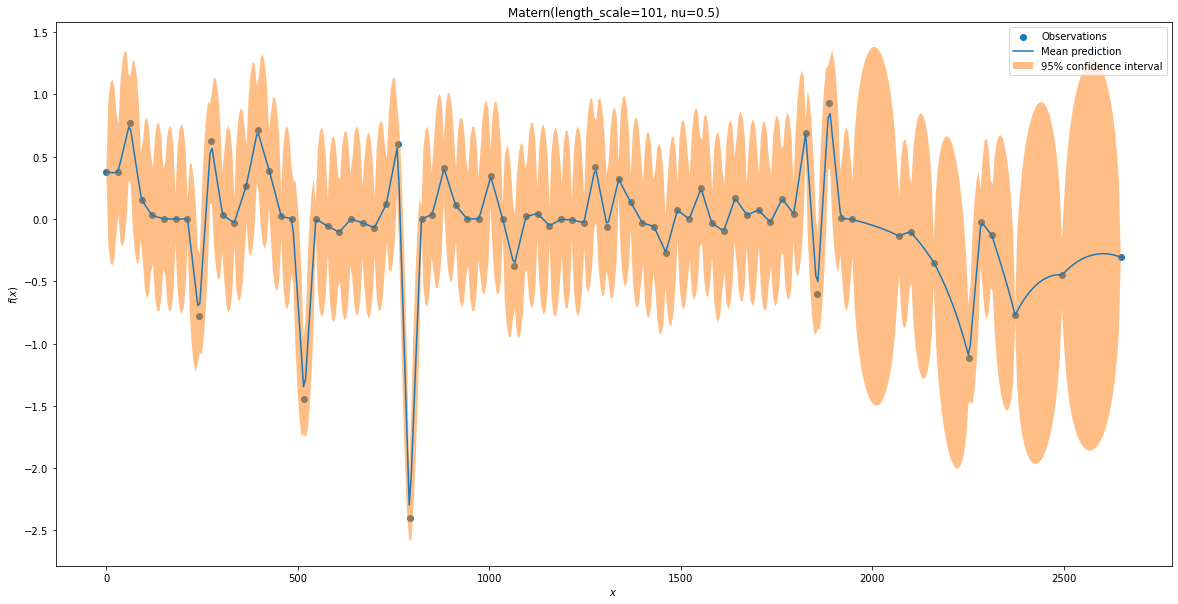

In [484]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 0.5), n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
plot_fit(gp, X_obs_diff, y_obs_diff)

Matern with $\nu = 0.5$ is basically linear interpolation

Matern(length_scale=34.9, nu=1.5)
-72.72873863172828


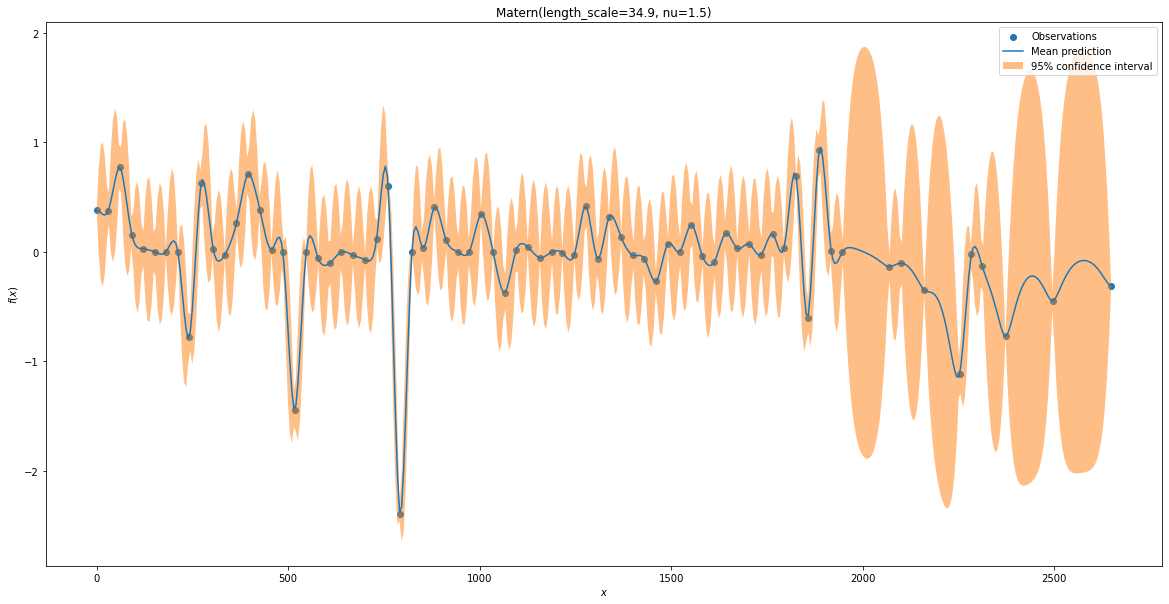

In [485]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5)  , n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, X_obs_diff, y_obs_diff)

RBF(length_scale=1)


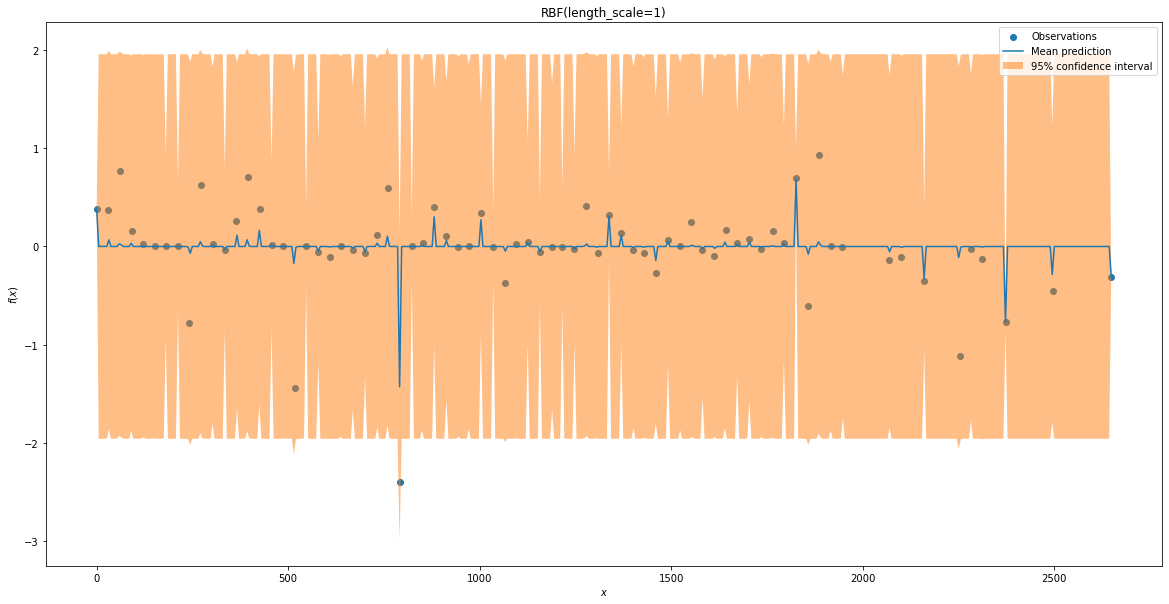

In [486]:
gp = gaussian_process.GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
plot_fit(gp, X_obs_diff, y_obs_diff)

Matern(length_scale=2.29e+03, nu=1.5)
-61.80975014303817


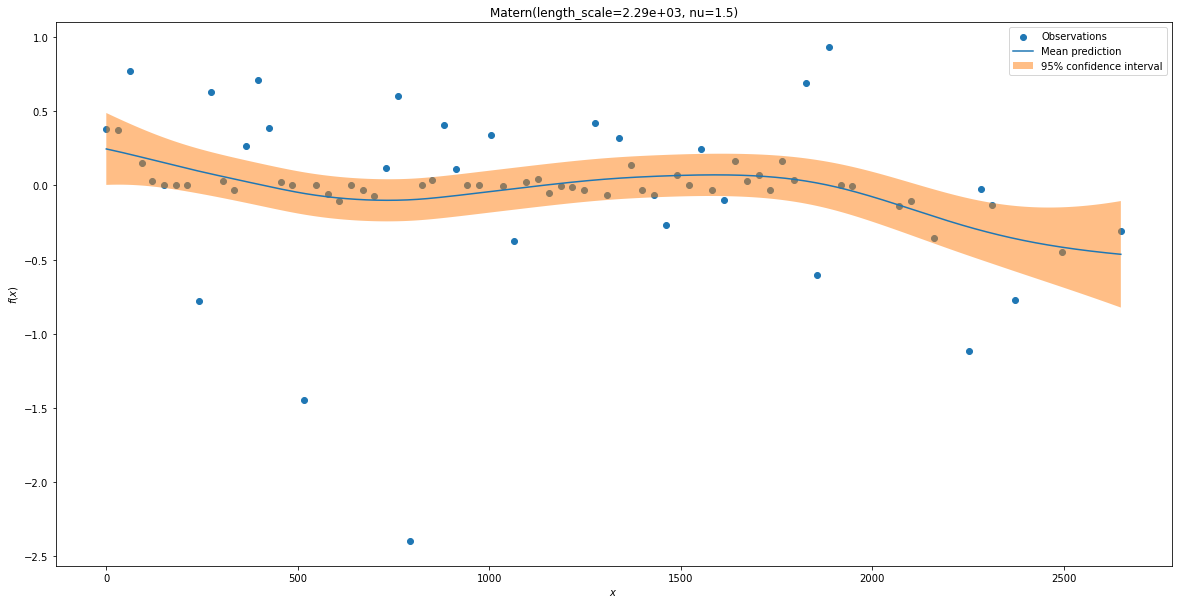

In [487]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5), alpha = 0.1  , n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, X_obs_diff, y_obs_diff)

# ESG companies

In [455]:
esg_diff.columns

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       ...
       'WY', 'WYNN', 'XEL', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS'],
      dtype='object', length=439)

In [490]:
esg_diff = pd.read_pickle('../Yahoo/refined.pkl')
esg = pd.read_pickle('../Yahoo/refined_no_diff.pkl')
company = 'A'
y_company_diff = np.array(esg_diff[company])
x_company_diff = np.expand_dims(np.array(range(len(y_company_diff))), axis = 1)

y_company = np.array(esg[company])
x_company = np.expand_dims(np.array(range(len(y_company))), axis = 1)


Matern(length_scale=42.6, nu=1.5)


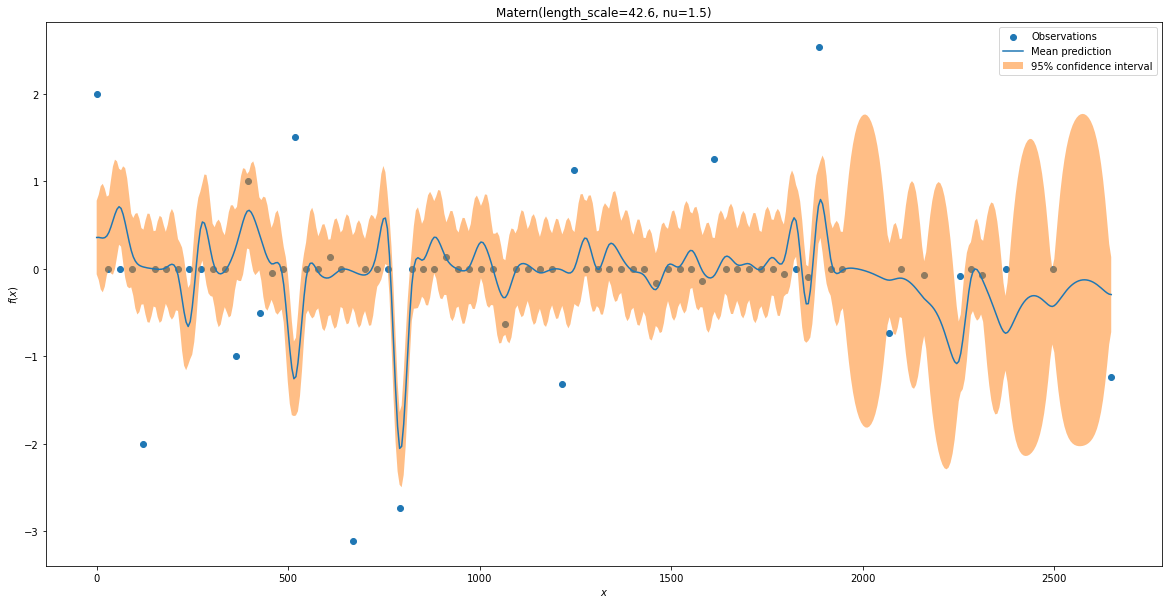

In [460]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=50, alpha= 0.05).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, x_company_diff, y_company_diff)

sector_esg_diff = pd.read_pickle('../Yahoo/sector_index.pkl')